In [175]:
import os
import io
import time
import json
import base64
import hashlib
import numpy as np
from tqdm import tqdm
from pathlib import Path
from io import BytesIO
from dotenv import load_dotenv
from PIL import Image
import cohere
import mimetypes
from openai import OpenAI
from pdf2image import convert_from_path
import PIL.Image
from functools import wraps
import cohere  # Make sure this is cohere.ClientV2 or Client


In [176]:
# ==== CONFIG ====
PDF_FOLDER = "source_docs"
IMG_FOLDER = "images"
HASHES_FOLDER = "hashes"
PDF_HASH_FILE = "pdf_hashes.json"
IMG_EMB_FILE = "image_embeddings.json"
MODEL_NAME = "embed-v4.0"

os.makedirs(PDF_FOLDER, exist_ok=True)
os.makedirs(IMG_FOLDER, exist_ok=True)
os.makedirs(HASHES_FOLDER, exist_ok=True)

In [177]:
# Load API keys
load_dotenv()
co = cohere.ClientV2(api_key=os.getenv("COHERE_API_KEY"))
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [178]:
# ==== HELPERS ====
def hash_file(filepath: str) -> str:
    sha256 = hashlib.sha256()
    with open(filepath, "rb") as f:
        while chunk := f.read(8192):
            sha256.update(chunk)
    return sha256.hexdigest()


def base64_from_image(img_path: str) -> str:
    with open(img_path, "rb") as f:
        b64_data = base64.b64encode(f.read()).decode("utf-8")
    mime_type, _ = mimetypes.guess_type(img_path)
    if not mime_type:
        mime_type = "image/png"  # fallback
    return f"data:{mime_type};base64,{b64_data}"



def embed_image(co, img_path: str):
    api_input_document = {
        "content": [{"type": "image", "image": base64_from_image(img_path)}]
    }
    api_response = co.embed(
        model=MODEL_NAME,
        input_type="search_document",
        embedding_types=["float"],
        inputs=[api_input_document],
    )
    return np.asarray(api_response.embeddings.float[0])


def convert_pdf_to_images(pdf_path: str, output_dir: str) -> list:
    pdf_name = Path(pdf_path).stem
    images = convert_from_path(pdf_path, dpi=200)
    image_paths = []

    for i, img in enumerate(images):
        img_filename = f"{pdf_name}_page{i + 1}.png"
        img_path = os.path.join(output_dir, img_filename)
        img.save(img_path, "PNG")
        image_paths.append(img_path)

    return image_paths


def load_json(path: str) -> dict:
    return json.load(open(path)) if os.path.exists(path) else {}


def save_json(path: str, data: dict):
    with open(path, "w") as f:
        json.dump(data, f, indent=2)

In [179]:
# ==== MAIN PIPELINE ====
def process_pdfs_and_embed_pages(co):
    pdf_hash_path = os.path.join(HASHES_FOLDER, PDF_HASH_FILE)
    img_emb_path = os.path.join(HASHES_FOLDER, IMG_EMB_FILE)

    pdf_hashes = load_json(pdf_hash_path)
    image_embeddings = load_json(img_emb_path)

    new_embeddings = 0

    for pdf_file in tqdm(os.listdir(PDF_FOLDER)):
        if not pdf_file.lower().endswith(".pdf"):
            continue

        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        pdf_name = Path(pdf_file).stem
        current_hash = hash_file(pdf_path)

        if pdf_name in pdf_hashes and pdf_hashes[pdf_name] == current_hash:
            print(f"✅ Skipping (unchanged): {pdf_file}")
            continue

        # New or changed PDF
        print(f"🔄 Processing: {pdf_file}")
        image_paths = convert_pdf_to_images(pdf_path, IMG_FOLDER)

        for img_path in image_paths:
            img_name = os.path.basename(img_path)

            if img_name in image_embeddings:
                continue  # image already embedded (unlikely for new PDF)

            emb = embed_image(co, img_path)
            image_embeddings[img_name] = emb.tolist()
            new_embeddings += 1

        # Save new hash
        pdf_hashes[pdf_name] = current_hash

    # Save updated JSONs
    save_json(pdf_hash_path, pdf_hashes)
    save_json(img_emb_path, image_embeddings)

    print(f"\n✅ Total embeddings stored: {len(image_embeddings)}")
    print(f"🆕 New embeddings added: {new_embeddings}")

In [180]:
process_pdfs_and_embed_pages(co)

 20%|██        | 1/5 [00:00<00:00,  4.93it/s]

✅ Skipping (unchanged): 2020TrustFundAnnualReports.pdf
🔄 Processing: 2021TrustFundAnnualReports.pdf


 40%|████      | 2/5 [03:56<06:57, 139.10s/it]

🔄 Processing: 2022TrustFundAnnualReports.pdf


 60%|██████    | 3/5 [09:48<07:52, 236.39s/it]

🔄 Processing: 2023TrustFundAnnualReports.pdf


 80%|████████  | 4/5 [15:17<04:32, 272.89s/it]

🔄 Processing: 2024TrustFundAnnualReports.pdf


100%|██████████| 5/5 [16:05<00:00, 193.14s/it]



✅ Total embeddings stored: 381
🆕 New embeddings added: 265


In [181]:
# def pdf_to_images_with_pdf_hash(
#     input_pdf: str,
#     images_folder: str = 'images',
#     hashes_folder: str = 'hashes',
#     dpi: int = 300,
#     fmt: str = 'png',
#     hash_filename: str = 'pdf_hashes.json'
# ):
#     pdf_path = Path(input_pdf)
#     images_dir = Path(images_folder)
#     hashes_dir = Path(hashes_folder)
#     images_dir.mkdir(parents=True, exist_ok=True)
#     hashes_dir.mkdir(parents=True, exist_ok=True)

#     hash_path = hashes_dir / hash_filename

#     # Load existing manifest if it exists
#     if hash_path.exists():
#         with open(hash_path, 'r') as f:
#             pdf_hashes = json.load(f)
#     else:
#         pdf_hashes = {}

#     # Compute hash of the entire PDF file
#     pdf_bytes = pdf_path.read_bytes()
#     pdf_hash = compute_sha256(pdf_bytes)

#     # Skip if already processed
#     if pdf_hash in pdf_hashes:
#         print(f"✔ Skipping {pdf_path.name}, already processed.")
#         return

#     # Convert to images
#     pages = convert_from_path(str(pdf_path), dpi=dpi)
#     image_filenames = []

#     for page_num, page in enumerate(pages, start=1):
#         filename = f"{pdf_path.stem}_page_{page_num}.{fmt}"
#         image_path = images_dir / filename

#         buffer = BytesIO()
#         page.save(buffer, format=fmt.upper())
#         image_path.write_bytes(buffer.getvalue())

#         image_filenames.append(filename)
#         print(f"🖼️ Saved: {filename}")

#     # Update hash manifest
#     pdf_hashes[pdf_hash] = {
#         "pdf": pdf_path.name,
#         "pages": image_filenames,
#         "num_pages": len(image_filenames)
#     }

#     with open(hash_path, 'w') as f:
#         json.dump(pdf_hashes, f, indent=2)

#     print(f"📘 PDF hash manifest updated at {hash_path}")


In [182]:
# def batch_process_pdfs_with_pdf_hashing(
#     source_folder: str = "source_docs",
#     images_folder: str = "images",
#     hashes_folder: str = "hashes",
#     dpi: int = 300,
#     fmt: str = "png",
#     manifest_filename: str = "pdf_hashes.json"
# ):
#     for pdf_path in Path(source_folder).glob("*.pdf"):
#         print(f"\n🔄 Processing: {pdf_path.name}")
#         pdf_to_images_with_pdf_hash(
#             input_pdf=str(pdf_path),
#             images_folder=images_folder,
#             hashes_folder=hashes_folder,
#             dpi=dpi,
#             fmt=fmt,
#             hash_filename=manifest_filename
#         )


In [183]:
# Convert images to a base64 string before sending it to the API
def base64_from_image(img_path):
    pil_image = Image.open(img_path)
    img_format = pil_image.format if pil_image.format else "PNG"

    # resize_image(pil_image)

    with io.BytesIO() as img_buffer:
        pil_image.save(img_buffer, format=img_format)
        img_buffer.seek(0)
        img_data = f"data:image/{img_format.lower()};base64,"+base64.b64encode(img_buffer.read()).decode("utf-8")

    return img_data

In [184]:
def retry(retries=3, backoff=2):
    def decorator(fn):
        def wrapper(*args, **kwargs):
            delay = backoff
            for attempt in range(retries):
                try:
                    return fn(*args, **kwargs)
                except Exception as e:
                    print(f"Attempt {attempt + 1} failed — retrying in {delay}s: {e}")
                    time.sleep(delay)
                    delay *= 2
            raise RuntimeError("All retries failed")
        return wrapper
    return decorator



In [185]:
@retry(retries=4, backoff=3)
def get_query_embedding(question: str, co) -> np.ndarray:
    """Generates an embedding for a given query string."""
    resp = co.embed(
        model=MODEL_NAME,
        input_type="search_query",
        embedding_types=["float"],
        texts=[question],
    )
    return np.asarray(resp.embeddings.float[0])

In [186]:
def load_image_embeddings(embeddings_path: str):
    """Load image embeddings and corresponding filenames."""
    with open(embeddings_path, "r") as f:
        image_embeddings = json.load(f)

    filenames = list(image_embeddings.keys())
    embeddings = np.vstack(list(image_embeddings.values()))
    
    return embeddings, filenames


In [187]:
def search_image_by_question(question: str, co, max_size=800,
                             embeddings_path="hashes/image_embeddings.json",
                             hash_manifest_path="hashes/pdf_hashes.json",
                             image_folder="images") -> str:
    """
    Embeds the query, searches for the most similar image page,
    and returns the matched image path.
    """
    # Step 1: Get query embedding
    query_emb = get_query_embedding(question, co)

    # Step 2: Load embeddings and filenames
    embeddings, filenames = load_image_embeddings(embeddings_path)

    # Step 3: Compute cosine similarity (dot product since vectors are normalized)
    idx = np.argmax(np.dot(query_emb, embeddings.T))
    img_path = os.path.join(image_folder, filenames[idx])

    # Step 4: Display image (optional)
    img = Image.open(img_path)
    img.thumbnail((max_size, max_size))
    img.show()

    return img_path

In [188]:
def encode_image_to_base64(img_path: str) -> str:
    """Encodes an image to base64 for embedding in a prompt."""
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")


def answer_question_about_image(question: str, img_path: str, client: OpenAI, model="gpt-4.1-mini", verbose=True) -> str:
    """
    Sends a multimodal prompt (text + image) to the LLM and returns the answer.

    Parameters:
    - question (str): User query
    - img_path (str): Local image path
    - client: OpenAI or AzureOpenAI client
    - model (str): Model to use (e.g., gpt-4.1-mini, gpt-4o)
    - verbose (bool): Whether to print the response

    Returns:
    - response text
    """
    try:
        b64 = encode_image_to_base64(img_path)

        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": f"Answer clearly: {question}"},
                        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64}"}},
                    ],
                },
            ],
            max_tokens=1000,
        )

        answer_text = response.choices[0].message.content.strip()
        if verbose:
            print("🧠 LLM Response:", answer_text)

        return answer_text

    except Exception as e:
        print(f"❌ Error processing image or getting response: {e}")
        return "Error occurred during processing."


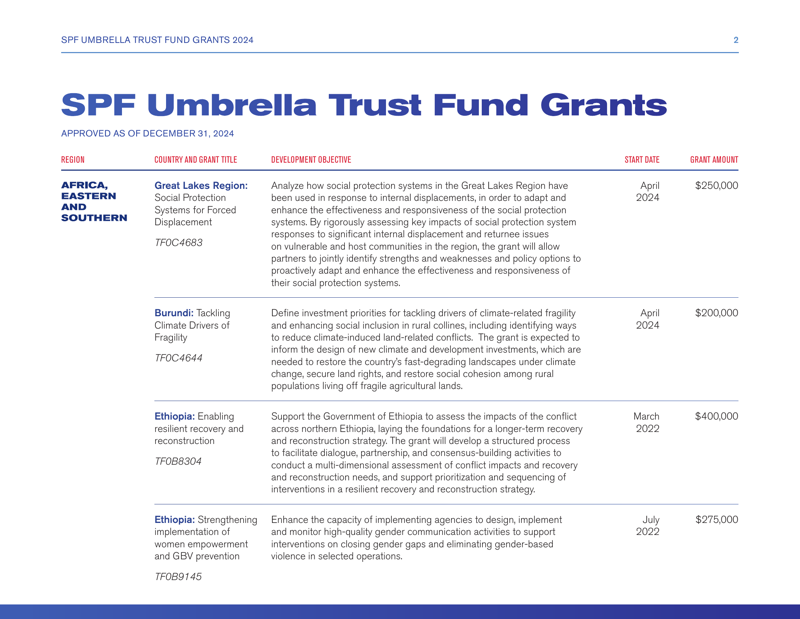

In [191]:
img_path = search_image_by_question("give me spf umberella trust funds grant for ethiopia", co)

In [193]:
answer = answer_question_about_image("give me spf umberella trust funds grant for ethiopia", img_path, client)

🧠 LLM Response: The SPF Umbrella Trust Fund Grants for Ethiopia are:

1. **Enabling resilient recovery and reconstruction**
   - Start Date: March 2022
   - Grant Amount: $400,000
   - Objective: Support the Government of Ethiopia to assess the impacts of the conflict across northern Ethiopia and develop a structured process for a longer-term recovery and reconstruction strategy.

2. **Strengthening implementation of women empowerment and GBV prevention**
   - Start Date: July 2022
   - Grant Amount: $275,000
   - Objective: Enhance the capacity of implementing agencies to design, implement, and monitor high-quality gender communication activities to support interventions on closing gender gaps and eliminating gender-based violence in selected operations.
